<a href="https://colab.research.google.com/github/Vaidehee-Bindal/Schizophrenia-Deep-Learning/blob/main/SchizoDetect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: mount drive to access the data from folder
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!mkdir -p /content/drive/MyDrive/EEG_Project/
!cp patient_dataset.csv /content/drive/MyDrive/EEG_Project/

cp: cannot stat 'patient_dataset.csv': No such file or directory


In [ ]:
!apt-get update
!apt-get install -y build-essential cmake

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,851 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,765 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-s

In [ ]:
!git clone https://github.com/fastlib/fCWT.git
%cd fCWT

Cloning into 'fCWT'...
remote: Enumerating objects: 705, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 705 (delta 84), reused 70 (delta 68), pack-reused 606 (from 2)
Receiving objects: 100% (705/705), 19.49 MiB | 19.74 MiB/s, done.
Resolving deltas: 100% (426/426), done.
/content/fCWT


In [ ]:
!pip install --no-cache-dir fCWT


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 7.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fCWT: filename=fcwt-0.1.18-cp311-cp311-linux_x86_64.whl size=4890046 sha256=e2c8ca9eaec5714a4fb7cbee3bee721ef61441ee1c0901a1089a1f7f7e2f5d5f
  Stored in directory: /tmp/pip-ephem-wheel-cache-76opi903/wheels/45/32/fc/c41c3b3da47873dd2e4e65712e62944d6814246c61e0364005
Successfully built fCWT


In [ ]:
!apt-get -y install libfftw3-dev libfftw3-single3

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3
  libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 40 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-single3 amd64 3.3.8-2ubuntu8 [800 kB]
Get:5 http://archive.ubuntu.com/ubuntu

In [ ]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 16.8 MB/s eta 0:00:00


In [ ]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import fCWT
import fcwt
import scipy.signal as signal
from scipy.signal import butter, filtfilt
from scipy.fft import fft, fftfreq
import os
from PIL import Image
import io
from tqdm import tqdm
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import tempfile
import pickle
import mne
from mne.preprocessing import compute_current_source_density
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import zipfile

with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall("data")  # Creating data/norm and data/sch, norm = healthy 35 and sch = schizophenic 45

In [ ]:
def load_and_flatten(data_path, label, max_len):
    rows = []
    for file in glob.glob(f"{data_path}/*.eea"):
        signal = np.loadtxt(file)
        # Pad or truncate
        signal = np.pad(signal, (0, max(0, max_len - len(signal))), mode='constant')[:max_len]
        row = list(signal) + [label]
        rows.append(row)
    return rows

MAX_LEN = 122880  # Set based on the longest .eea file you'd like to include

# Load data
norm_rows = load_and_flatten("data/norm", label=0, max_len=MAX_LEN)
sch_rows = load_and_flatten("data/sch", label=1, max_len=MAX_LEN)

# Combine and create DataFrame
all_rows = norm_rows + sch_rows
np.random.shuffle(all_rows)

# Create column names: signal_0, signal_1, ..., signal_499, label
columns = [f"signal_{i}" for i in range(MAX_LEN)] + ["label"]
df = pd.DataFrame(all_rows, columns=columns)

# Save as CSV
df.to_csv("patient_dataset.csv", index=False)

In [ ]:
# Load your EEG data (each patient should be a column)
df = pd.read_csv("/content/drive/MyDrive/EEG_Project/patient_dataset.csv")  # uploaded file

# Get the numpy array of shape
data = df.values  # shape: (84,122881)

In [ ]:
df.head(10)

,signal_0,signal_1,signal_2,signal_3,signal_4,signal_5,signal_6,signal_7,signal_8,signal_9,...,signal_122871,signal_122872,signal_122873,signal_122874,signal_122875,signal_122876,signal_122877,signal_122878,signal_122879,label
0,409.33,389.94,629.08,728.18,769.11,788.50,667.86,489.04,168.04,129.26,...,-922.07,-1411.11,-1680.41,-1740.73,-1281.85,-51.70,308.08,829.43,939.31,0
1,308.45,248.96,328.28,429.63,469.29,429.63,508.94,627.92,887.90,808.58,...,-321.67,-420.82,-491.32,-581.65,-550.81,-451.66,-370.14,-121.18,-50.67,0
2,148.97,109.99,48.73,29.24,69.61,109.99,189.35,208.84,169.86,29.24,...,318.83,79.36,-11.14,-190.74,-270.10,-391.23,-410.72,-370.35,-270.10,0
3,-351.20,-330.23,-272.57,-214.91,-31.45,26.21,146.77,167.74,188.71,225.40,...,-283.06,0.00,188.71,277.82,214.91,-31.45,-172.98,-414.10,-513.70,1
4,29.50,9.83,-19.67,-59.00,-59.00,49.17,285.18,265.52,127.84,68.84,...,-39.34,88.51,78.67,354.02,511.36,403.19,226.18,0.00,-108.17,1
5,-71.15,9.70,148.76,129.36,48.51,9.70,29.11,48.51,189.19,289.44,...,1039.73,1099.56,999.31,489.95,38.81,-981.52,-1460.15,-1930.70,-1961.42,1
6,-10.19,-130.38,-291.31,-270.94,8.15,107.97,169.08,69.26,-71.30,-91.67,...,-330.01,-751.70,-1010.42,-1370.99,-1411.73,-1110.23,-790.41,8.15,338.16,1
7,28.66,-30.70,-90.06,-30.70,88.02,128.95,88.02,49.13,-10.23,8.19,...,458.51,339.79,278.38,198.55,118.72,-151.47,-321.36,-440.08,-380.72,1
8,-137.02,-205.53,-154.15,-85.64,-51.38,-119.89,-222.66,-205.53,-17.13,0.00,...,-462.44,-479.57,-513.83,-804.99,-976.27,-1147.54,-1164.67,-1010.52,-856.38,1
9,228.97,69.32,-170.15,-191.16,-210.06,-151.25,-111.33,-151.25,-331.90,-350.81,...,-1390.62,-691.11,-430.63,-191.16,-81.92,199.56,388.62,258.38,-21.01,0


In [ ]:
df.shape

(84, 122881)

In [ ]:
# Load your EEG data (each patient should be a column)
df = pd.read_csv("/content/drive/MyDrive/EEG_Project/patient_dataset.csv")  # uploaded file

# Get the numpy array
data = df.values

# Separate features and labels
labels = data[:, -1]  # Get the last column as labels
features = data[:, :-1] # Get all columns except the last one as features

# You can check the shapes to confirm separation
print("Shape of features:", features.shape)
print("Shape of labels:", labels.shape)

Shape of features: (84, 122880)
Shape of labels: (84,)


In [ ]:
c = 0
for i in labels:
  if i == 1:
    c+=1
print(c)

45


In [ ]:
patients = []

for i in range(features.shape[0]):  # for 84 patients (rows)
    patient_signals = features[i, :].reshape(16, 7680)
    patients.append(patient_signals)  # list of shape (84, 16, 7680)

# Now 'patients' contains the reshaped features and 'labels' contains the corresponding labels.
# You can now use 'patients' and 'labels' to train your supervised learning model.

In [ ]:
print("Shape of the patients list (number of patients):", len(patients))

# Assuming all inner arrays have the same shape, you can check the shape of the first element
if len(patients) > 0:
    print("Shape of each patient's data:", patients[0].shape)

Shape of the patients list (number of patients): 84
Shape of each patient's data: (16, 7680)


In [ ]:
print((patients[0][0]))

[409.33 389.94 629.08 ...  28.01 269.3  329.62]


In [ ]:
print((patients[0][-1]))

[ 579.53  159.42 -611.84 ...  308.08  829.43  939.31]


In [ ]:
def butter_bandpass_filter(signal, lowcut=2.0, highcut=45.0, fs=128, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, signal)
    return y

In [ ]:
def plot_fft(signal, fs, title):
    N = len(signal)
    yf = fft(signal)
    xf = fftfreq(N, 1 / fs)

    plt.plot(xf[:N // 2], np.abs(yf[:N // 2]))
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

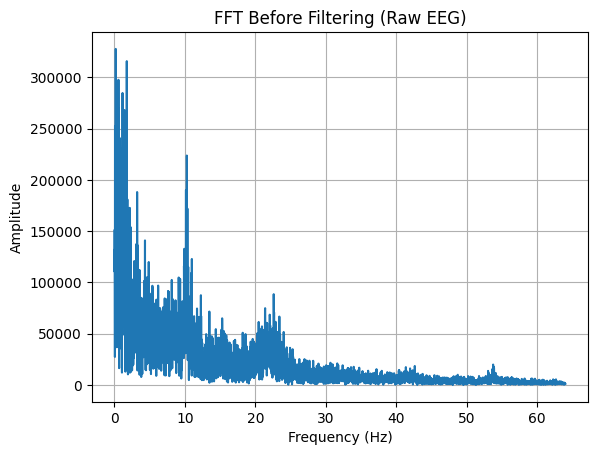

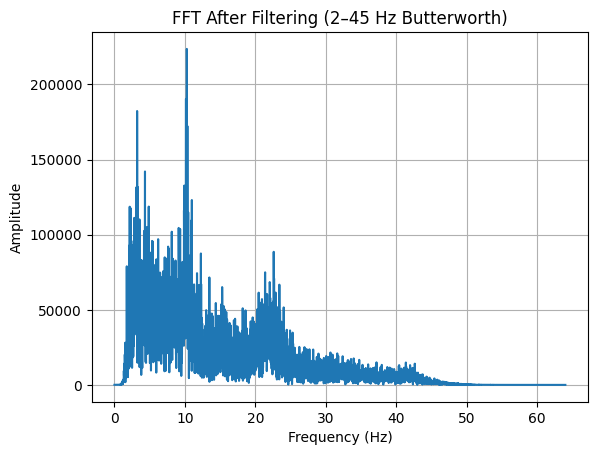

In [ ]:
fs = 128  # Sampling frequency

# Access the first patient (patients is a list)
patient = patients[0]        # shape (16, 7680)

# Access the first channel
signal = patient[0, :]       # shape (7680,)

# Plot before filtering
plot_fft(signal, fs, title="FFT Before Filtering (Raw EEG)")

# Apply Butterworth 2–45 Hz filter
filtered_signal = butter_bandpass_filter(signal, 2.0, 45.0, fs)

# Plot after filtering
plot_fft(filtered_signal, fs, title="FFT After Filtering (2–45 Hz Butterworth)")

In [ ]:
# 2nd Order Butterworth Bandpass Filter Function
def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

In [ ]:
def plot_fft(signal, fs, title="FFT"):
    n = len(signal)
    f = np.fft.rfftfreq(n, d=1/fs)
    fft_magnitude = np.abs(np.fft.rfft(signal))

    plt.figure(figsize=(10, 4))
    plt.plot(f, fft_magnitude)
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

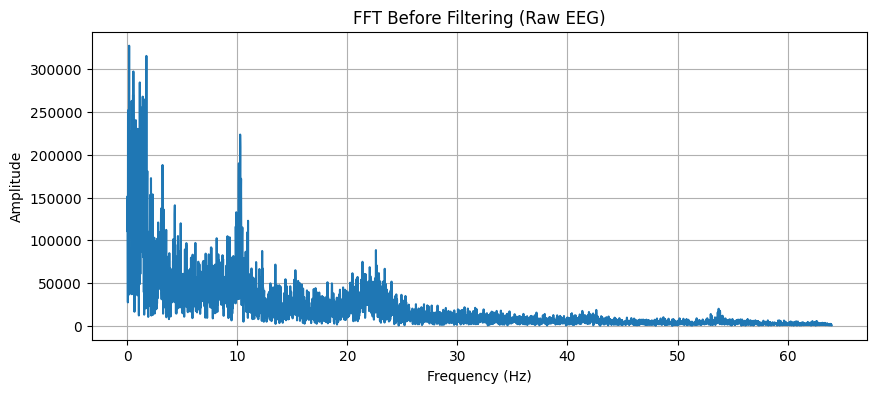

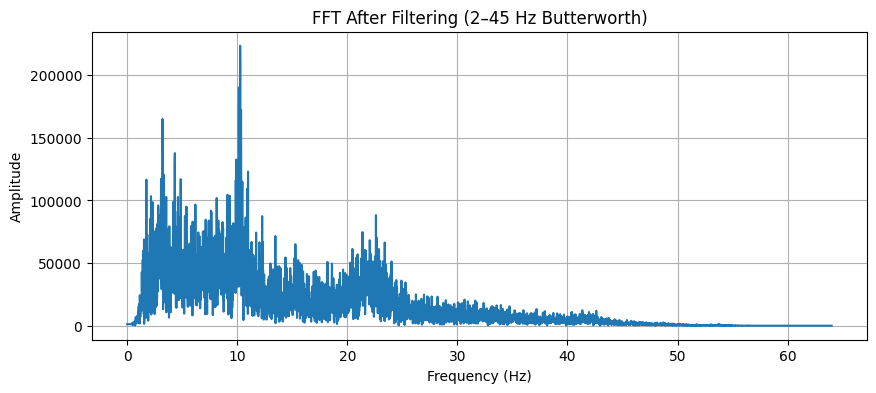

In [ ]:
fs = 128  # Sampling Frequency in Hz

# First patient
patient = patients[0]        # shape (16, 7680)

# First channel
signal = patient[0, :]       # shape (7680,)

# Plot FFT before filtering
plot_fft(signal, fs, title="FFT Before Filtering (Raw EEG)")

# Apply Butterworth Filter (2–45 Hz)
filtered_signal = butter_bandpass_filter(signal, 2.0, 45.0, fs, order=2)

# Plot FFT after filtering
plot_fft(filtered_signal, fs, title="FFT After Filtering (2–45 Hz Butterworth)")

In [ ]:
def rereference_with_csd(signal_matrix, fs=128):
    # signal_matrix shape: (16 channels, timepoints)
    ch_names = ['F7', 'F3', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']

    info = mne.create_info(ch_names=ch_names, sfreq=fs, ch_types='eeg')

    # Average Reference
    avg_ref = signal_matrix - np.mean(signal_matrix, axis=0, keepdims=True)

    # Standard Reference to Cz (Index 6)
    cz_ref = avg_ref - avg_ref[6:7, :]

    # Apply CSD (Current Source Density)
    raw = mne.io.RawArray(cz_ref * 1e-6, info)  # µV to V for MNE
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage)
    raw_csd = compute_current_source_density(raw)
    csd_data = raw_csd.get_data() * 1e6  # Convert back to µV

    return csd_data

In [ ]:
def save_scalogram_for_cnn(patient_id, channel_id, segment_idx, signal, save_root, fs=128):
    bandwidth = 3.0
    wavelet = fcwt.Morlet(bandwidth)

    f0, f1, fn = 2.0, 45.0, 100
    scales = fcwt.Scales(wavelet, 0, fs, f0, f1, fn)
    transform = fcwt.FCWT(wavelet, 1, True, True)

    output = np.empty((scales.nscales, len(signal)), dtype=np.complex64)
    transform.cwt(signal.astype(np.float32), scales, output)
    scalogram = np.abs(output)

    save_dir = os.path.join(save_root, f"P{patient_id}/Ch{channel_id}")
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"Seg_{segment_idx}.png")

    if os.path.exists(save_path):
        print(f"Skipping existing: {save_path}")
        return

    fig, ax = plt.subplots(figsize=(5, 5), dpi=200)
    cax = ax.imshow(
        scalogram,
        extent=[0, len(signal)/fs, f0, f1],
        cmap='jet',
        origin='lower',
        interpolation='bicubic',
        aspect='auto'
    )
    ax.axis('off')
    fig.savefig(save_path, bbox_inches='tight', pad_inches=0, dpi=200)
    plt.close(fig)

    img = Image.open(save_path).resize((256, 256))
    img.save(save_path)

Streaming output truncated to the last 5000 lines.
Skipping existing: /content/drive/MyDrive/EEG_Project/Scalograms_ReReferenced/P8/Ch15/Seg_7.png
Skipping existing: /content/drive/MyDrive/EEG_Project/Scalograms_ReReferenced/P8/Ch15/Seg_8.png
Skipping existing: /content/drive/MyDrive/EEG_Project/Scalograms_ReReferenced/P8/Ch15/Seg_9.png
Skipping existing: /content/drive/MyDrive/EEG_Project/Scalograms_ReReferenced/P8/Ch16/Seg_1.png
Skipping existing: /content/drive/MyDrive/EEG_Project/Scalograms_ReReferenced/P8/Ch16/Seg_2.png
Skipping existing: /content/drive/MyDrive/EEG_Project/Scalograms_ReReferenced/P8/Ch16/Seg_3.png
Skipping existing: /content/drive/MyDrive/EEG_Project/Scalograms_ReReferenced/P8/Ch16/Seg_4.png
Skipping existing: /content/drive/MyDrive/EEG_Project/Scalograms_ReReferenced/P8/Ch16/Seg_5.png
Skipping existing: /content/drive/MyDrive/EEG_Project/Scalograms_ReReferenced/P8/Ch16/Seg_6.png
Skipping existing: /content/drive/MyDrive/EEG_Project/Scalograms_ReReferenced/P8/Ch16

KeyboardInterrupt: 

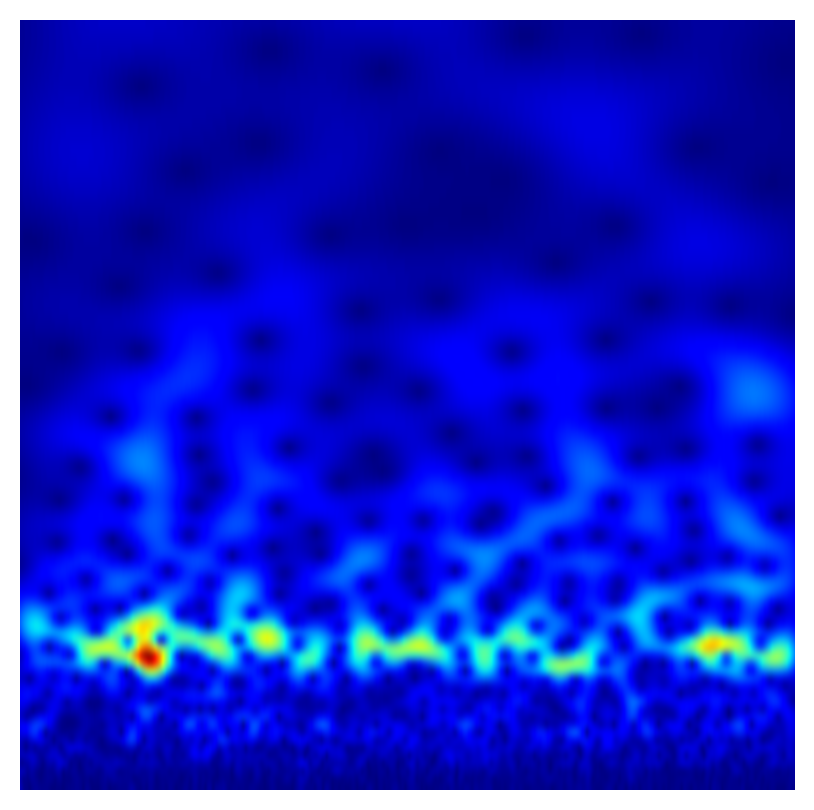

In [ ]:
save_root = "/content/drive/MyDrive/EEG_Project/Scalograms_ReReferenced"
fs = 128
window_size = 20 * fs  # 20 seconds
step_size = 5 * fs     # 5 seconds

for idx, patient in enumerate(patients):
    # Re-reference + CSD
    patient_reref = rereference_with_csd(patient, fs=fs)

    for ch in range(patient_reref.shape[0]):  # 16 channels
        signal = patient_reref[ch, :]

        # utterworth Filter (2-45 Hz)
        filtered_signal = butter_bandpass_filter(signal, 2.0, 45.0, fs, order=2)

        # Segmenting into Windows + Save Scalograms
        start_points = np.arange(0, len(filtered_signal) - window_size + 1, step_size)

        for win_idx, start in enumerate(start_points):
            segment = filtered_signal[start:start + window_size]
            save_scalogram_for_cnn(
                patient_id=idx + 1,
                channel_id=ch + 1,
                segment_idx=win_idx + 1,
                signal=segment,
                save_root=save_root,
                fs=fs
            )

print("\nAll filtered, re-referenced, CSD-applied scalograms saved.")

In [ ]:
# DONT RUN

# Butterworth Filter Function

def butter_bandpass_filter(signal, lowcut=2.0, highcut=45.0, fs=128, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, signal)
    return y

# Your Existing Scalogram Function (Unchanged)

def save_scalogram_for_cnn(patient_id, channel_id, segment_idx, signal, save_root, fs=128):
    # Morlet wavelet for CWT
    bandwidth = 3.0
    wavelet = fcwt.Morlet(bandwidth)

    # Scales for full EEG range 2-45 Hz
    f0, f1, fn = 2.0, 45.0, 100
    scales = fcwt.Scales(wavelet, 0, fs, f0, f1, fn)  # 0 = LOG scale
    transform = fcwt.FCWT(wavelet, 1, True, True)

    # Create output buffer
    output = np.empty((scales.nscales, len(signal)), dtype=np.complex64)

    # Apply CWT
    transform.cwt(signal.astype(np.float32), scales, output)
    scalogram = np.abs(output)

    # Directory path
    save_dir = os.path.join(save_root, f"P{patient_id}/Ch{channel_id}")
    os.makedirs(save_dir, exist_ok=True)

    # Save path
    save_path = os.path.join(save_dir, f"Seg_{segment_idx}.png")

    # Skip if file already exists
    if os.path.exists(save_path):
        print(f"Skipping existing: {save_path}")
        return

    # Plot scalogram as image - high quality for CNN
    fig, ax = plt.subplots(figsize=(5, 5), dpi=200)
    cax = ax.imshow(
        scalogram,
        extent=[0, len(signal)/fs, f0, f1],
        cmap='jet',
        origin='lower',
        interpolation='bicubic',
        aspect='auto'
    )
    ax.axis('off')

    # Save high-quality PNG
    fig.savefig(save_path, bbox_inches='tight', pad_inches=0, dpi=200)
    plt.close(fig)

    # Optional: Ensure CNN-standard size (224x224 or 256x256)
    img = Image.open(save_path).resize((256, 256))
    img.save(save_path)

# Your Existing Main Loop + Added Filtering

save_root = "/content/drive/MyDrive/EEG_Project/Scalograms_CNN_Fixed"

fs = 128
window_size = 20 * fs
step_size = 5 * fs

for idx, patient in enumerate(patients):
    for ch in range(patient.shape[0]):  # 16 channels
        signal = patient[ch, :]

        # Apply Butterworth filtering here (NEW)
        filtered_signal = butter_bandpass_filter(signal, 2.0, 45.0, fs)

        # Proceed with segmentation on the filtered signal
        start_points = np.arange(0, len(filtered_signal) - window_size + 1, step_size)

        for win_idx, start in enumerate(start_points):
            segment = filtered_signal[start:start + window_size]
            save_scalogram_for_cnn(
                patient_id=idx + 1,
                channel_id=ch + 1,
                segment_idx=win_idx + 1,
                signal=segment,
                save_root=save_root,
                fs=fs
            )

print("All filtered scalograms saved.")

In [ ]:
# DONT RUN

# Paths
save_root = "/content/drive/MyDrive/EEG_Project/Scalograms_CNN_Fixed"
features_save_path = '/content/drive/MyDrive/EEG_Project/efficientnetb3_features.pkl'

# Load EfficientNetB3 (no classification head)
base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)

# Load existing features safely (prevent EOFError)
features = {}
if os.path.exists(features_save_path):
    if os.path.getsize(features_save_path) > 0:
        try:
            with open(features_save_path, 'rb') as f:
                features = pickle.load(f)
            print(f"Resuming. Loaded {len(features)} existing features.")
        except EOFError:
            print("Existing features file is corrupted. Removing and starting fresh.")
            os.remove(features_save_path)
            features = {} # Reset features dictionary
    else:
        print("Existing features file is empty. Starting fresh.")
        os.remove(features_save_path)
        features = {} # Reset features dictionary

else:
    print("No existing features file found. Starting fresh.")

# Collect all .png paths not already processed
image_paths = []
for root, dirs, files in os.walk(save_root):
    for file in files:
        if file.endswith('.png'):
            full_path = os.path.join(root, file)
            if full_path not in features:
                image_paths.append(full_path)

print(f"Found {len(image_paths)} images to process...")

# Efficient batch processing
batch_size = 32
all_batches = [image_paths[i:i + batch_size] for i in range(0, len(image_paths), batch_size)]

for batch_paths in tqdm(all_batches):
    batch_imgs = []
    for img_path in batch_paths:
        img = load_img(img_path, target_size=(256, 256))
        img_array = img_to_array(img)
        batch_imgs.append(img_array)

    batch_array = np.array(batch_imgs, dtype='float32')
    batch_array = preprocess_input(batch_array)

    # Predict features in batch (GPU efficient)
    batch_features = model.predict(batch_array, verbose=0)

    for img_path, feature in zip(batch_paths, batch_features):
        features[img_path] = feature

    # Save after each batch to prevent loss on disconnect
    with open(features_save_path, 'wb') as f:
        pickle.dump(features, f)

In [ ]:
# --------------------- Paths ---------------------
save_root = "/content/drive/MyDrive/EEG_Project/Scalograms_CNN_Fixed"
features_save_path = '/content/drive/MyDrive/EEG_Project/efficientnetb3_features.pkl'


# --------------------- Safe Load Function ---------------------
features = {}
if os.path.exists(features_save_path):
    if os.path.getsize(features_save_path) > 0:
        try:
            with open(features_save_path, 'rb') as f:
                features = pickle.load(f)
            print(f"[INFO] Resuming. Loaded {len(features)} existing features.")
        except (EOFError, pickle.UnpicklingError):
            print("[WARNING] Existing features file is corrupted. Removing and starting fresh.")
            os.remove(features_save_path)
            features = {}
    else:
        print("[INFO] Existing features file is empty. Starting fresh.")
        os.remove(features_save_path)
else:
    print("[INFO] No existing features file found. Starting fresh.")


# --------------------- Safe Save Function ---------------------
def safe_pickle_save(obj, filename):
    dir_name = os.path.dirname(filename)
    with tempfile.NamedTemporaryFile(mode='wb', dir=dir_name, delete=False) as tmpfile:
        pickle.dump(obj, tmpfile)
        temp_name = tmpfile.name
    os.replace(temp_name, filename)


# --------------------- Load Model ---------------------
base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)


# --------------------- Gather New Images Only ---------------------
all_image_paths = []
for root, dirs, files in os.walk(save_root):
    for file in files:
        if file.endswith('.png'):
            full_path = os.path.join(root, file)
            all_image_paths.append(full_path)

# Filter to only images not yet processed
image_paths = [p for p in all_image_paths if p not in features]
print(f"[INFO] Found {len(image_paths)} new images to process... (Total {len(all_image_paths)} images in directory)")


# --------------------- Batch Processing ---------------------
batch_size = 32
all_batches = [image_paths[i:i + batch_size] for i in range(0, len(image_paths), batch_size)]

for batch_paths in tqdm(all_batches, desc="Processing Batches"):
    try:
        batch_imgs = []
        for img_path in batch_paths:
            img = load_img(img_path, target_size=(256, 256))
            img_array = img_to_array(img)
            batch_imgs.append(img_array)

        batch_array = np.array(batch_imgs, dtype='float32')
        batch_array = preprocess_input(batch_array)

        # Predict features
        batch_features = model.predict(batch_array, verbose=0)

        # Save features for these images
        for img_path, feature in zip(batch_paths, batch_features):
            features[img_path] = feature

        # Save after every batch safely
        safe_pickle_save(features, features_save_path)

    except Exception as e:
        print(f"[ERROR] Skipping current batch due to error: {e}")
        continue


# --------------------- Done ---------------------
print(f"[INFO] Finished processing. Total features saved: {len(features)}")

[INFO] Resuming. Loaded 96 existing features.
[INFO] Found 12000 new images to process... (Total 12096 images in directory)


Processing Batches:   2%|▏         | 8/375 [04:25<3:22:45, 33.15s/it]


KeyboardInterrupt: 

In [ ]:
# --------------------- Paths ---------------------
save_root = "/content/drive/MyDrive/EEG_Project/Scalograms_ReReferenced"
features_save_path = '/content/drive/MyDrive/EEG_Project/efficientnetb3_features.pkl'


# --------------------- Safe Load Function ---------------------
features = {}
if os.path.exists(features_save_path):
    if os.path.getsize(features_save_path) > 0:
        try:
            with open(features_save_path, 'rb') as f:
                features = pickle.load(f)
            print(f"[INFO] Resuming. Loaded {len(features)} existing features.")
        except (EOFError, pickle.UnpicklingError):
            print("[WARNING] Existing features file is corrupted. Removing and starting fresh.")
            os.remove(features_save_path)
            features = {}
    else:
        print("[INFO] Existing features file is empty. Starting fresh.")
        os.remove(features_save_path)
else:
    print("[INFO] No existing features file found. Starting fresh.")


# --------------------- Safe Save Function ---------------------
def safe_pickle_save(obj, filename):
    dir_name = os.path.dirname(filename)
    with tempfile.NamedTemporaryFile(mode='wb', dir=dir_name, delete=False) as tmpfile:
        pickle.dump(obj, tmpfile)
        temp_name = tmpfile.name
    os.replace(temp_name, filename)


# --------------------- Load EfficientNetB3 + GAP ---------------------
from tensorflow.keras.layers import GlobalAveragePooling2D
base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
model = Model(inputs=base_model.input, outputs=x)


# --------------------- Gather Images ---------------------
all_image_paths = []
for root, dirs, files in os.walk(save_root):
    for file in files:
        if file.endswith('.png'):
            full_path = os.path.join(root, file)
            all_image_paths.append(full_path)

# Filter only images not yet processed
image_paths = [p for p in all_image_paths if p not in features]
print(f"[INFO] Found {len(image_paths)} new images to process... (Total {len(all_image_paths)} images in directory)")


# --------------------- Batch Processing ---------------------
batch_size = 32
all_batches = [image_paths[i:i + batch_size] for i in range(0, len(image_paths), batch_size)]

for batch_paths in tqdm(all_batches, desc="Processing Batches"):
    try:
        batch_imgs = []
        for img_path in batch_paths:
            img = load_img(img_path, target_size=(256, 256))
            img_array = img_to_array(img)
            batch_imgs.append(img_array)

        batch_array = np.array(batch_imgs, dtype='float32')
        batch_array = preprocess_input(batch_array)

        # Predict features
        batch_features = model.predict(batch_array, verbose=0)

        # Save features
        for img_path, feature in zip(batch_paths, batch_features):
            features[img_path] = feature

        # Safe save after each batch
        safe_pickle_save(features, features_save_path)

    except Exception as e:
        print(f"[ERROR] Skipping current batch due to error: {e}")
        continue


# --------------------- Done ---------------------
print(f"[INFO] Finished processing. Total features saved: {len(features)}")

NameError: name 'os' is not defined

In [ ]:
# --------------------- Paths ---------------------
save_root = "/content/drive/MyDrive/EEG_Project/Scalograms_ReReferenced"
features_save_path = '/content/drive/MyDrive/EEG_Project/densenet169_features.pkl'


# --------------------- Safe Load Function ---------------------
features = {}
if os.path.exists(features_save_path):
    if os.path.getsize(features_save_path) > 0:
        try:
            with open(features_save_path, 'rb') as f:
                features = pickle.load(f)
            print(f"[INFO] Resuming. Loaded {len(features)} existing features.")
        except (EOFError, pickle.UnpicklingError):
            print("[WARNING] Existing features file is corrupted. Removing and starting fresh.")
            os.remove(features_save_path)
            features = {}
    else:
        print("[INFO] Existing features file is empty. Starting fresh.")
        os.remove(features_save_path)
else:
    print("[INFO] No existing features file found. Starting fresh.")


# --------------------- Safe Save Function ---------------------
def safe_pickle_save(obj, filename):
    dir_name = os.path.dirname(filename)
    with tempfile.NamedTemporaryFile(mode='wb', dir=dir_name, delete=False) as tmpfile:
        pickle.dump(obj, tmpfile)
        temp_name = tmpfile.name
    os.replace(temp_name, filename)


# --------------------- Load DenseNet169 + GAP ---------------------
from tensorflow.keras.layers import GlobalAveragePooling2D
base_model = DenseNet169(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
model = Model(inputs=base_model.input, outputs=x)


# --------------------- Gather New Images Only ---------------------
all_image_paths = []
for root, dirs, files in os.walk(save_root):
    for file in files:
        if file.endswith('.png'):
            full_path = os.path.join(root, file)
            all_image_paths.append(full_path)

# Filter only images not yet processed
image_paths = [p for p in all_image_paths if p not in features]
print(f"[INFO] Found {len(image_paths)} new images to process... (Total {len(all_image_paths)} images in directory)")


# --------------------- Batch Processing (Efficient) ---------------------
batch_size = 32
all_batches = [image_paths[i:i + batch_size] for i in range(0, len(image_paths), batch_size)]

for batch_paths in tqdm(all_batches, desc="Processing Batches (DenseNet169)"):
    try:
        batch_imgs = []
        for img_path in batch_paths:
            img = load_img(img_path, target_size=(256, 256))
            img_array = img_to_array(img)
            batch_imgs.append(img_array)

        batch_array = np.array(batch_imgs, dtype='float32')
        batch_array = preprocess_input(batch_array)

        # Predict features
        batch_features = model.predict(batch_array, verbose=0)

        # Save features
        for img_path, feature in zip(batch_paths, batch_features):
            features[img_path] = feature

        # Safe save after each batch
        safe_pickle_save(features, features_save_path)

    except Exception as e:
        print(f"[ERROR] Skipping current batch due to error: {e}")
        continue


# --------------------- Done ---------------------
print(f"[INFO] Finished processing. Total features saved: {len(features)}")